In [20]:
!pip install pandas numpy scikit-learn xgboost tqdm numpy_financial fredapi


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, auc
from tqdm import tqdm

In [22]:
pd.set_option('display.max_columns', None) # 모든 열 다 보기
pd.set_option('display.max_rows', None) # 모든 행 다 보기
pd.set_option('display.width', None) # 열 너비 넉넉하게
pd.set_option('display.max_colwidth', None) # 열 안의 값 자르지 않게
tqdm.pandas()

# AWS S3에서 데이터 load
# url = "https://snu-bigdata-fintech-ai.s3.ap-northeast-2.amazonaws.com/data/interim/preprocessed_data_ver.3.0.csv"
#df = pd.read_csv(url)

path = "../stat_proj/data/prepro_data_ver.2.3_js.csv"
df = pd.read_csv(path)


df.head()

,funded_amnt,term,installment,emp_length,annual_inc,issue_d,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,revol_util,total_acc,recoveries,collection_recovery_fee,last_pymnt_d,last_fico_range_high,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,default,addr_state_AK,addr_state_AL,addr_state_AR,addr_state_AZ,addr_state_CA,addr_state_CO,addr_state_CT,addr_state_DC,addr_state_DE,addr_state_FL,addr_state_GA,addr_state_HI,addr_state_ID,addr_state_IL,addr_state_IN,addr_state_KS,addr_state_KY,addr_state_LA,addr_state_MA,addr_state_MD,addr_state_ME,addr_state_MI,addr_state_MN,addr_state_MO,addr_state_MS,addr_state_MT,addr_state_NC,addr_state_ND,addr_state_NE,addr_state_NH,addr_state_NJ,addr_state_NM,addr_state_NV,addr_state_NY,addr_state_OH,addr_state_OK,addr_state_OR,addr_state_PA,addr_state_RI,addr_state_SC,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY,addr_state_nan,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_OWN,home_ownership_RENT,home_ownership_nan,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,purpose_nan,emp_length_missing,percent_bc_gt_75_missing,delinq_amnt_missing,tax_liens_missing,mths_since_last_delinq_missing,fico_range_low_missing,open_il_12m_missing,fico_range_high_missing,mths_since_recent_inq_missing,open_acc_missing,all_util_missing,open_acc_6m_missing,annual_inc_missing,inq_last_6mths_missing,collection_recovery_fee_missing,mths_since_recent_revol_delinq_missing,last_fico_range_high_missing,acc_now_delinq_missing,open_rv_24m_missing,total_bal_il_missing,total_acc_missing,revol_bal_missing,mths_since_rcnt_il_missing,open_act_il_missing,collections_12_mths_ex_med_missing,pub_rec_bankruptcies_missing,pub_rec_missing,funded_amnt_missing,open_rv_12m_missing,open_il_24m_missing,delinq_2yrs_missing,inq_last_12m_missing,chargeoff_within_12_mths_missing,il_util_missing,installment_missing,max_bal_bc_missing,recoveries_missing
0,4425.0,36,160.53,10.0,11.156265,2016-03-01,2.776954,1,665.0,669.0,1.0,8.0,14.0,0,8.217439,63.4,21.0,0.00,0.00,Mar-2019,569.0,0,0,0,61209.0,2.0,9.0,0.0,0.0,29.0,57505.0,102.0,2.0,3.0,7.565793,100.0,8.476580,2.0,3.0,8.383205,4.584967,94.6,0,0.0,144.0,124.0,2.0,2.0,0.0,13.0,4.0,37.0,3.0,5.0,2.0,2.0,16.0,5.0,5.0,5.0,14.0,0,0,1,2.0,73.7,100.0,0,0,11.021069,11.022066,7.824446,10.939320,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,4000.0,36,136.89,0.0,10.596660,2012-08-01,2.598979,0,705.0,709.0,3.0,0.0,4.0,0,9.015420,36.6,9.0,200.57,1.76,Feb-2013,514.0,0,0,0,79938.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,10.128669,0.0,5.0,8.902932,9.392745,0.0,0,0.0,0.0,162.0,8.0,6.0,0.0,11.0,0.0,0.0,0.0,5.0,2.0,7.0,7.0,7.0,13.0,5.0,4.0,0,0,0,2.0,100.0,0.0,0,0,11.647898,9.015420,9.392745,10.372866,1,0,0,0,0,1,0,0,0,0,0,0,0,0,

In [23]:
# 독립변수에서 제외할 변수 목록
# drop_cols = [
#    'term', 'last_pymnt_d', 'installment', 'funded_amnt',
#    'recoveries', 'collection_recovery_fee', 'default', 'issue_d',
#    'risk_free_rate', 'cash_flow', 'irr'
#]

# X = df.drop(columns=drop_cols)
# y = df['default']

# 독립변수에서 제외할 변수 목록
drop_cols = [
    'term', 'last_pymnt_d', 'installment', 'funded_amnt',
    'recoveries', 'collection_recovery_fee', 'default', 'issue_d'
]

X = df.drop(columns=drop_cols)
y = df['default']

In [24]:
from fredapi import Fred

# FRED API 연결
fred = Fred(api_key="f9ef939a9a1eeff85d31ed2c984507d9")  # 🔑 실제 API 키로 대체해야 함

# 미국 3년 만기 국채 수익률(GS3) 시계열 불러오기
series = fred.get_series('GS3')  # pandas.Series 형식으로 반환됨


print(series.head())

1953-04-01    2.51
1953-05-01    2.72
1953-06-01    2.74
1953-07-01    2.62
1953-08-01    2.58
dtype: float64


In [25]:
df['last_pymnt_d'] = pd.to_datetime(df['last_pymnt_d'])
df['issue_d'] = pd.to_datetime(df['issue_d'])  # 혹시 모르니 이것도

/var/folders/2q/_8m2fvxd4pv04q2b3gk8j0bm0000gn/T/ipykernel_87278/4242469769.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['last_pymnt_d'] = pd.to_datetime(df['last_pymnt_d'])


In [26]:
def get_nearest_rate(issue_date, rate_series):
    if pd.isnull(issue_date):
        return np.nan
    try:
        idx = rate_series.index.get_indexer([issue_date], method='nearest')[0]
        return rate_series.iloc[idx] / 100  # % 단위 → 소수로 변환
    except Exception as e:
        print(f"Error: {issue_date} ▶ {e}")
        return np.nan


df['risk_free_rate'] = df['issue_d'].apply(lambda x: get_nearest_rate(x, series))

In [27]:
from dateutil.relativedelta import relativedelta

def create_cash_flow_from_dates(row):
    try:
        term = int(row['term'])
        default = int(row['default'])
        issue_d = row['issue_d']  # 이미 datetime 형식
        last_pymnt_d = pd.to_datetime(row['last_pymnt_d'])  # 이건 문자열일 수도 있으니 변환
        installment = float(row['installment'])
        funded_amnt = float(row['funded_amnt'])
        recoveries = float(row['recoveries'])
        collection_fee = float(row['collection_recovery_fee'])

        # 첫 현금흐름: 대출 실행
        cash_flow = [-funded_amnt]

        if pd.isnull(issue_d) or pd.isnull(last_pymnt_d):
            return np.nan

        # 몇 회차까지 납입했는지 계산
        delta = relativedelta(last_pymnt_d, issue_d)
        last_pymnt_num = delta.years * 12 + delta.months

        for month in range(1, term + 1):
            if default == 1:
                if month <= last_pymnt_num:
                    cash_flow.append(installment)
                elif month == last_pymnt_num + 1:
                    cash_flow.append(recoveries - collection_fee)
                else:
                    cash_flow.append(0)
            else:
                cash_flow.append(installment)

        return cash_flow

    except Exception as e:
        print(f"[오류] index={row.name}, error={e}")
        return np.nan


In [28]:
df['cash_flow'] = df.apply(create_cash_flow_from_dates, axis=1)

In [29]:
!pip install numpy-financial

import numpy_financial as npf

def get_irr(cash_flow):
    if not isinstance(cash_flow, list) or len(cash_flow) == 0:
        return np.nan
    irr_monthly = npf.irr(cash_flow)
    if irr_monthly is None or np.isnan(irr_monthly):
        return np.nan
    return (1 + irr_monthly) ** 12 - 1  # 연환산


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [30]:
df['irr'] = df['cash_flow'].apply(get_irr)

In [31]:
df['irr'] = df['irr'].fillna(df['risk_free_rate'])

In [32]:
# Sharpe 계산 함수
def calculate_sharpe(returns, risk_free_rates):
    excess = returns - risk_free_rates
    if excess.std(ddof=1) == 0:
        return -np.inf
    return excess.mean() / excess.std(ddof=1)

In [33]:
# 하이퍼파라미터 범위 지정
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 1, 5],
    'min_child_weight': [1, 3, 5],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [1, 5, 10]
}

# 튜닝용 고정된 데이터셋으로 하이퍼파라미터 탐색 1회 수행
X_tune, _, y_tune, _ = train_test_split(X, y, test_size=0.3, stratify=y)

model_base = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
search = RandomizedSearchCV(
    model_base, param_distributions=param_dist, n_iter=9,
    scoring='roc_auc', cv=2, n_jobs=1
)
search.fit(X_tune, y_tune)

best_params = search.best_params_
print("✅ Best hyperparameters (from tuning):", best_params)

/opt/anaconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [17:40:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [17:40:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [17:40:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [17:40:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

✅ Best hyperparameters (from tuning): {'subsample': 0.6, 'reg_lambda': 1, 'reg_alpha': 0, 'n_estimators': 300, 'min_child_weight': 1, 'max_depth': 10, 'learning_rate': 0.05, 'gamma': 5, 'colsample_bytree': 1.0}


In [34]:
# 결과 저장용 리스트
best_models = []
best_thresholds = []
validation_sharpes = []
test_sharpes = []
test_approval_rates = []
test_irr_means = []
test_irr_positive_rates = []

# 해당 best 파라미터를 기반으로 100번 반복 학습 및 평가
for i in tqdm(range(100)):
    # Train-test split
    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y, test_size=0.2, random_state=i, stratify=y
    )
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=0.25, random_state=i, stratify=y_temp
    )

    # best 하이퍼파라미터로 모델 생성 및 학습
    model = XGBClassifier(**best_params, eval_metric='logloss')
    model.fit(X_train, y_train)

    # 검증 세트 예측 및 threshold 탐색
    y_pred_proba = model.predict_proba(X_val)[:, 1]
    thresholds = np.arange(0.0, 1.0, 0.05)

    best_sharpe = -np.inf
    best_threshold = None
    val_indices = X_val.index
    df_val = df.loc[val_indices]

    for threshold in thresholds:
        approved_mask = y_pred_proba <= threshold
        denied_mask = ~approved_mask

        selected = df_val.copy()
        selected.loc[approved_mask, 'irr_adj'] = selected.loc[approved_mask, 'irr']
        selected.loc[denied_mask, 'irr_adj'] = selected.loc[denied_mask, 'risk_free_rate']

        returns = selected['irr_adj']
        risk_free = selected['risk_free_rate']
        valid = returns.notnull() & risk_free.notnull()

        if valid.sum() < 2:
            continue

        sharpe = calculate_sharpe(returns[valid], risk_free[valid])

        if sharpe > best_sharpe:
            best_sharpe = sharpe
            best_threshold = threshold

    best_models.append(model)
    best_thresholds.append(best_threshold)
    validation_sharpes.append(best_sharpe)

    # Test 데이터 평가
    y_test_proba = model.predict_proba(X_test)[:, 1]
    test_approved_mask = y_test_proba <= best_threshold
    df_test = df.loc[X_test.index]
    test_selected = df_test[test_approved_mask]

    returns_test = test_selected['irr']
    risk_free_test = test_selected['risk_free_rate']
    valid = returns_test.notnull() & risk_free_test.notnull()

    returns_test = returns_test[valid]
    risk_free_test = risk_free_test[valid]

    sharpe_test = calculate_sharpe(returns_test, risk_free_test)
    test_sharpes.append(sharpe_test)
    test_approval_rates.append(len(returns_test) / len(df_test))
    test_irr_means.append(returns_test.mean())
    test_irr_positive_rates.append((returns_test > 0).mean())

# 최종 결과 출력
best_idx = np.argmax(test_sharpes)
print("✅ Best model index:", best_idx)
print("✅ Best validation Sharpe ratio:", validation_sharpes[best_idx])
print("✅ Best test Sharpe ratio:", test_sharpes[best_idx])
print("✅ Best approval rate:", test_approval_rates[best_idx])
print("✅ Mean IRR:", test_irr_means[best_idx])
print("✅ Positive IRR ratio:", test_irr_positive_rates[best_idx])
print("✅ Best threshold:", best_thresholds[best_idx])
print("✅ Best model params:", best_models[best_idx].get_params())


100%|██████████| 100/100 [00:30<00:00,  3.25it/s]

✅ Best model index: 89
✅ Best validation Sharpe ratio: 0.6603543216760056
✅ Best test Sharpe ratio: 1.9469762998154383
✅ Best approval rate: 0.5861526357199056
✅ Mean IRR: 0.1278978841286745
✅ Positive IRR ratio: 0.9986577181208054
✅ Best threshold: 0.05
✅ Best model params: {'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 1.0, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': 'logloss', 'feature_types': None, 'feature_weights': None, 'gamma': 5, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.05, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 10, 'max_leaves': None, 'min_child_weight': 1, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 300, 'n_jobs': None, 'num_parallel_tree': None, 'ran

In [35]:
print("Best thresholds from 2 runs:")
print(best_thresholds)

print("\nValidation Sharpe Ratios from 2 runs:")
print(validation_sharpes)

print("\nTest Sharpe Ratios from 2 runs:")
print(test_sharpes)

print("\nTest Approval Rates:")
print(test_approval_rates)

print("\nTest IRR Means:")
print(test_irr_means)

print("\nTest IRR Positive Rates:")
print(test_irr_positive_rates)

Best thresholds from 2 runs:
[np.float64(0.1), np.float64(0.1), np.float64(0.1), np.float64(0.05), np.float64(0.05), np.float64(0.05), np.float64(0.2), np.float64(0.05), np.float64(0.05), np.float64(0.05), np.float64(0.1), np.float64(0.1), np.float64(0.05), np.float64(0.15000000000000002), np.float64(0.1), np.float64(0.1), np.float64(0.05), np.float64(0.05), np.float64(0.05), np.float64(0.05), np.float64(0.1), np.float64(0.05), np.float64(0.05), np.float64(0.05), np.float64(0.1), np.float64(0.05), np.float64(0.05), np.float64(0.05), np.float64(0.05), np.float64(0.1), np.float64(0.05), np.float64(0.1), np.float64(0.05), np.float64(0.2), np.float64(0.05), np.float64(0.05), np.float64(0.05), np.float64(0.05), np.float64(0.05), np.float64(0.05), np.float64(0.05), np.float64(0.1), np.float64(0.05), np.float64(0.05), np.float64(0.05), np.float64(0.1), np.float64(0.05), np.float64(0.1), np.float64(0.05), np.float64(0.05), np.float64(0.15000000000000002), np.float64(0.05), np.float64(0.05), np

/var/folders/2q/_8m2fvxd4pv04q2b3gk8j0bm0000gn/T/ipykernel_87278/2488281667.py:21: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/anaconda3/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


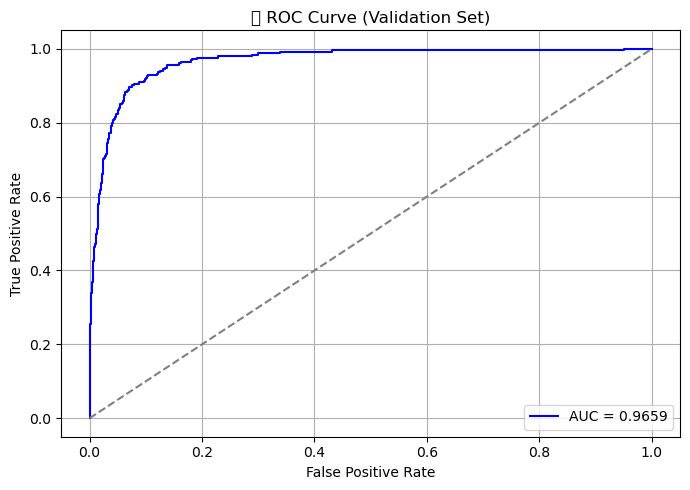

/var/folders/2q/_8m2fvxd4pv04q2b3gk8j0bm0000gn/T/ipykernel_87278/2488281667.py:54: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/anaconda3/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


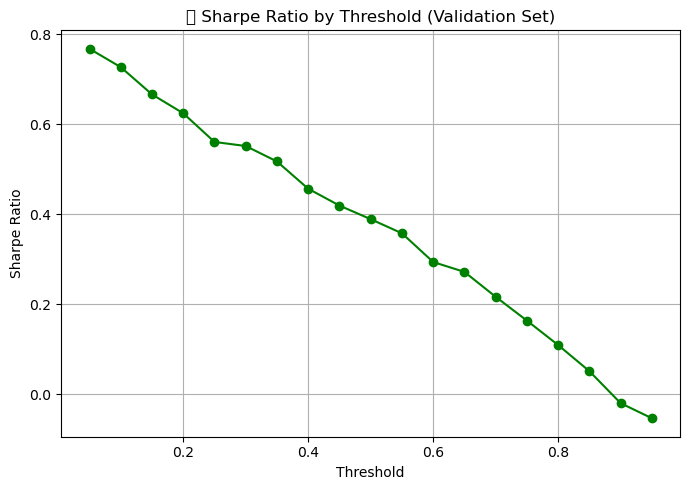

In [36]:
# 최적 모델
best_model = best_models[best_idx]

# 검증 데이터에서 예측 확률
y_val_proba = best_model.predict_proba(X_val)[:, 1]

# --------------------------
# 1. ROC Curve 시각화
# --------------------------
fpr, tpr, roc_thresholds = roc_curve(y_val, y_val_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}", color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title("✅ ROC Curve (Validation Set)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --------------------------
# 2. Threshold별 Sharpe Ratio
# --------------------------
thresholds = np.arange(0.0, 1.0, 0.05)
sharpe_ratios = []

for threshold in thresholds:
    approved_mask = y_val_proba <= threshold
    denied_mask = ~approved_mask

    selected = df_val.copy()
    selected.loc[approved_mask, 'irr_adj'] = selected.loc[approved_mask, 'irr']
    selected.loc[denied_mask, 'irr_adj'] = selected.loc[denied_mask, 'risk_free_rate']

    returns = selected['irr_adj']
    risk_free = selected['risk_free_rate']
    valid = returns.notnull() & risk_free.notnull()

    if valid.sum() < 2:
        sharpe_ratios.append(np.nan)
    else:
        sharpe = calculate_sharpe(returns[valid], risk_free[valid])
        sharpe_ratios.append(sharpe)

plt.figure(figsize=(7, 5))
plt.plot(thresholds, sharpe_ratios, marker='o', color='green')
plt.title("✅ Sharpe Ratio by Threshold (Validation Set)")
plt.xlabel("Threshold")
plt.ylabel("Sharpe Ratio")
plt.grid(True)
plt.tight_layout()
plt.show()


/opt/anaconda3/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


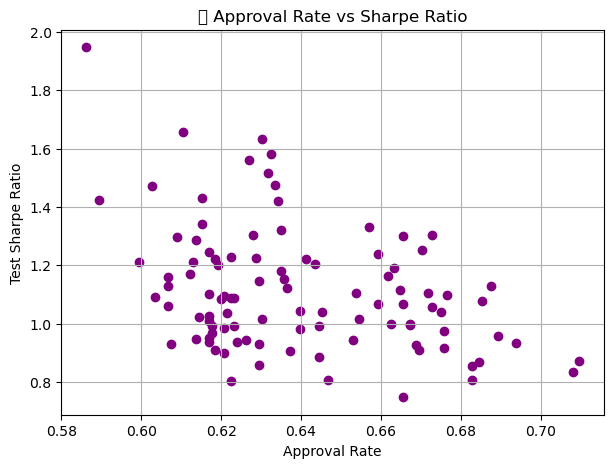

In [37]:
# 🔍 IRR 평균 및 Positive 비율 비교
plt.figure(figsize=(7, 5))
plt.scatter(test_approval_rates, test_sharpes, color='purple')
plt.title("🎯 Approval Rate vs Sharpe Ratio")
plt.xlabel("Approval Rate")
plt.ylabel("Test Sharpe Ratio")
plt.grid(True)
plt.show()